In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abtem
import os
import sys
import dask
import importlib
from ase.io import read, write
from ase.visualize import view

#paths [part I]
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_folder = os.path.abspath(os.path.join(parent_dir, 'data', ))
results_folder = os.path.abspath(os.path.join(parent_dir, 'results/images_DFT'))

#import homemade modules by adding hBN_sim directory to sys.path
sys.path.insert(0, parent_dir)

import helper_funcs
from helper_funcs import create_parameter_list

#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

### RAW

In [2]:
#CHOOSE - which data?
data_dir = f'{data_folder}/data_DFT/'

In [3]:
#import preparation
data_names = [entry for entry in os.listdir(data_dir) if entry.endswith('.zarr')]
measurements_list = [None] * len(data_names)
#sort by timestamp
data_names.sort()

#fill measurements_list with imported data
for i in range(len(data_names)):
    path = f'{data_dir}{data_names[i]}'
    measurements_list[i] = abtem.from_zarr(path).compute()

[########################################] | 100% Completed | 103.16 ms
[########################################] | 100% Completed | 102.95 ms
[########################################] | 100% Completed | 101.70 ms
[########################################] | 100% Completed | 101.70 ms


In [4]:
len(measurements_list)

4

In [5]:
data_names

['20240918180059_relax_pathC_Nsite.traj_RAW.zarr',
 '20240918184208_relax_pathC_Bsite.traj_RAW.zarr',
 '20240918192307_relax_hBN_B4_outplane.traj_RAW.zarr',
 '20240918193004_relax_hBN_B4_inplane.traj_RAW.zarr']

In [6]:
#params1 = ['_'.join([name.split('_')[1], name.split('_')[2].lstrip('path'), name.split('_')[3].rstrip('.traj')]) for name in data_names[:2]]
#params2 = ['_'.join([name.split('_')[1], name.split('_')[3].rstrip('4'), 'Nsite\n', name.split('_')[4].rstrip('.traj')]) for name in data_names[2:]]

#MANUAL INPUT! 
params1 = ['DFT vacancyN filledwithC', 'DFT vacancyB filledwithC']
params2 = ['DFT vacancyN filledwithB\noutplane', 'DFT vacancyN filledwithB\ninplane']

# new
params1 = [r'$C_N$', r'$C_B$',]
params2 = [r'$B_N$ - outplane', r'$B_N$ - inplane']


parameter_info = [params1, params2] # seperation for plots below

In [7]:
#measurements = abtem.stack([m for m in measurements_list], parameter_info)
measurements1 = abtem.stack([m for m in measurements_list[:2]], params1)
measurements2 = abtem.stack([m for m in measurements_list[2:]], params2)
measurements = [measurements1, measurements2]

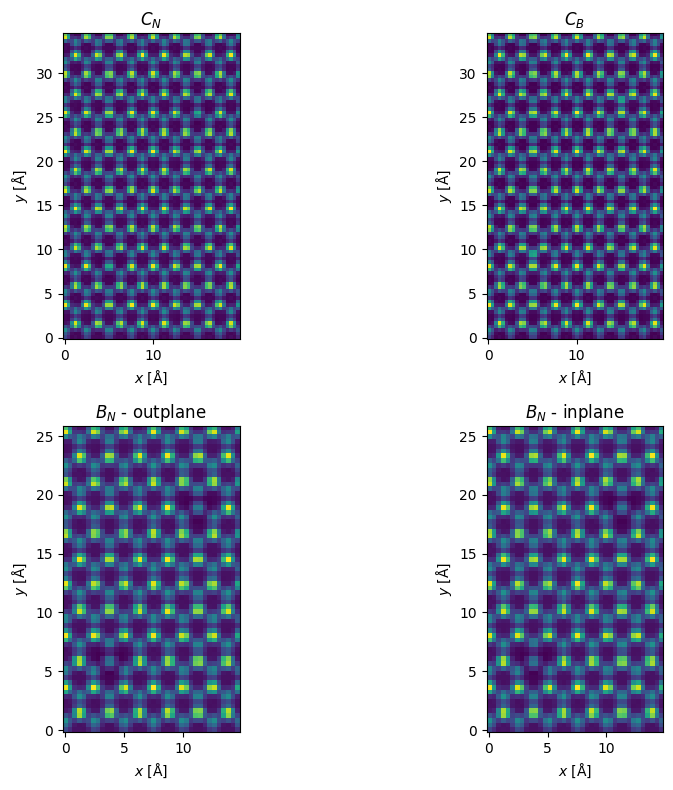

In [8]:
#plot RAW
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*4))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            measurements[row][col].show(ax=axs[row, col], explode=False, cbar=False, title=True)
            axs[row, col].set_title(parameter_info[row][col])
            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(25,35)
                axs[row, col].set_xlim(20,30)
        except IndexError:
            axs[row, col].set_visible(False)
        
plt.tight_layout()

### INTERPOLATED + GAUSS

In [9]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9

In [10]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements1 = measurements1.interpolate(interpolate).gaussian_filter(gauss)
final_measurements2 = measurements2.interpolate(interpolate).gaussian_filter(gauss)
final_measurements = [final_measurements1, final_measurements2]

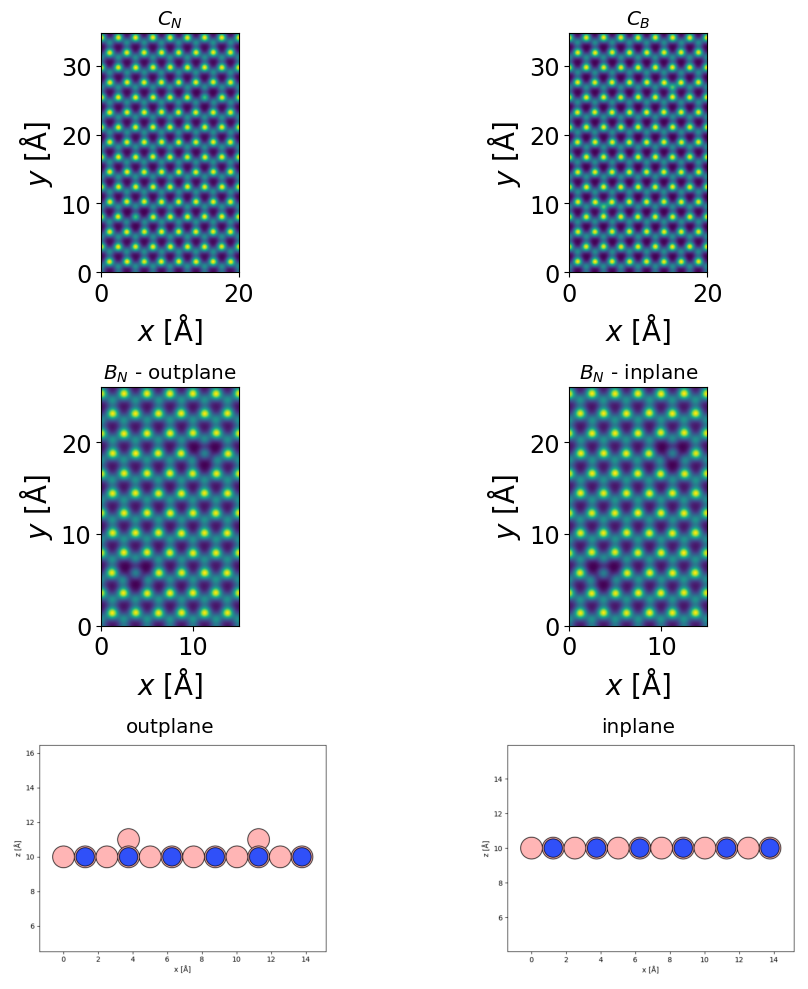

In [203]:
#plot
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            final_measurements[row][col].show(ax=axs[row, col], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[row, col].set_title(parameter_info[row][col])

            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(2,12)
                axs[row, col].set_xlim(1,9)
        except IndexError:
            axs[row, col].set_visible(False)

#
im_out = plt.imread(f'{results_folder}/structure/outplane_xz.png')
im_in = plt.imread(f'{results_folder}/structure/inplane_xz.png')
images = [im_out, im_in]

row = rows
for i in range(2):
    axs[row, i].imshow(images[i])
    axs[row, i].set_axis_off()

axs[row, 0].set_title('outplane')
axs[row, 1].set_title('inplane')


#plt.subplots_adjust(wspace = 0.1)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC1.png', bbox_inches='tight')

In [11]:
from matplotlib.gridspec import GridSpec

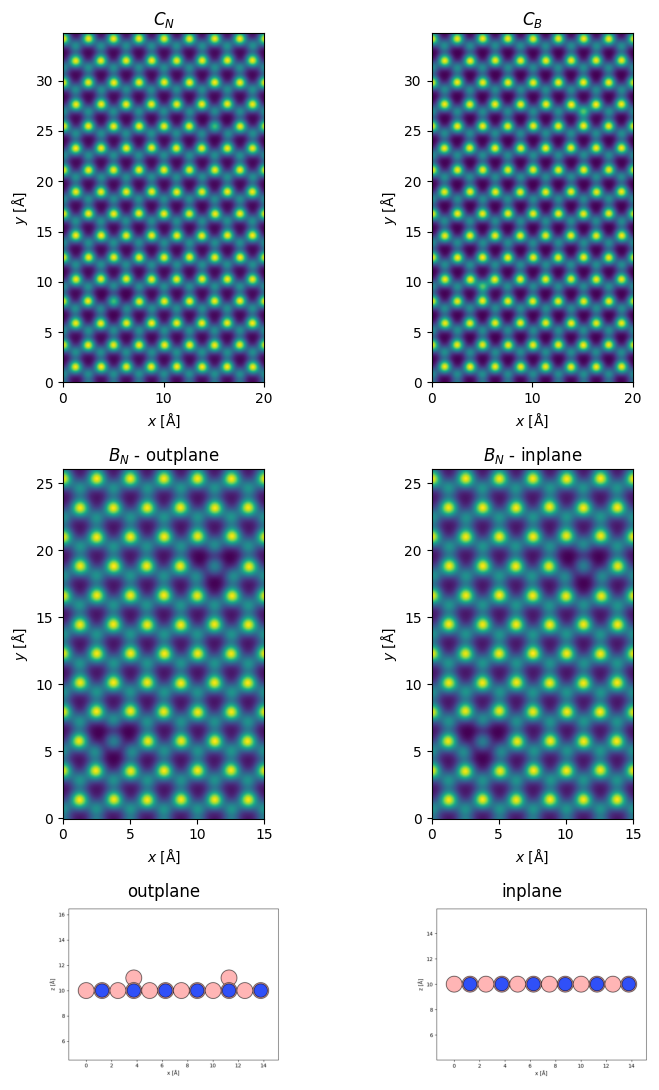

In [12]:
#plot
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
#fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

fig = plt.figure(figsize=(8,11))

gs = GridSpec(3, 2, height_ratios=[3,3, 1.5],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

i=0
for row in range(rows):
    for col in range(columns):
        
        try:
            final_measurements[row][col].show(ax=axs[i], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[i].set_title(parameter_info[row][col])

            if zoom == 'yes':
                axs[i].set_ylim(2,12)
                axs[i].set_xlim(1,9)
                
            i += 1
                
        except IndexError:
            axs[i].set_visible(False)

#
im_out = plt.imread(f'{results_folder}/structure/outplane_xz.png')
im_in = plt.imread(f'{results_folder}/structure/inplane_xz.png')
images = [im_out, im_in]

for i in range(2):
    axs[i+4].imshow(images[i])
    axs[i+4].set_axis_off()

axs[4].set_title('outplane')
axs[5].set_title('inplane')


#plt.subplots_adjust(hspace = 0.5)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC.png', bbox_inches='tight')

### NOISE

In [13]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)
noisy_measurements1 = final_measurements1.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements2 = final_measurements2.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements = [noisy_measurements1, noisy_measurements2]

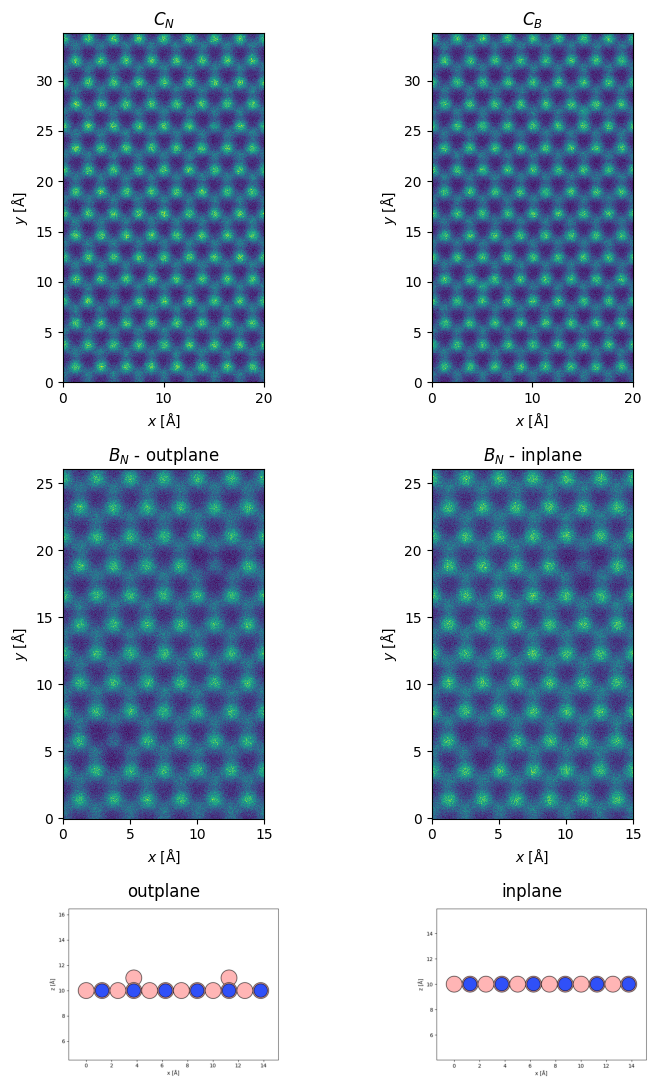

In [14]:
#plot
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
#fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

fig = plt.figure(figsize=(8,11))

gs = GridSpec(3, 2, height_ratios=[3,3, 1.5],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

i=0
for row in range(rows):
    for col in range(columns):
        
        try:
            noisy_measurements[row][col].show(ax=axs[i], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[i].set_title(parameter_info[row][col])

            if zoom == 'yes':
                axs[i].set_ylim(2,12)
                axs[i].set_xlim(1,9)
                
            i += 1
                
        except IndexError:
            axs[i].set_visible(False)

#
im_out = plt.imread(f'{results_folder}/structure/outplane_xz.png')
im_in = plt.imread(f'{results_folder}/structure/inplane_xz.png')
images = [im_out, im_in]

for i in range(2):
    axs[i+4].imshow(images[i])
    axs[i+4].set_axis_off()

axs[4].set_title('outplane')
axs[5].set_title('inplane')


#plt.subplots_adjust(hspace = 0.5)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC_noisy_zoom.png', bbox_inches='tight')

In [13]:
#noisy_measurements_plot = abtem.stack(noisy_measurements, parameter_info)
#noisy_measurements_plot[5:7].show(explode=True, figsize=(12, 4))


### View: Outplane vs Inplane

In [15]:
atoms_outplane = read(f'{data_dir}input_trajectories/relax_hBN_B4_outplane.traj', index = ':')
atoms_inplane = read(f'{data_dir}input_trajectories/relax_hBN_B4_inplane.traj', index = ':')
CB = read(f'{data_dir}input_trajectories/relax_pathC_Bsite.traj', index = ':')
CN = read(f'{data_dir}input_trajectories/relax_pathC_Nsite.traj', index = ':')


#image_out  = write('./data/data_DFT/outplane.png', atoms_outplane[0])
#image_in  = write('./data/data_DFT/inplane.png', atoms_inplane[0])


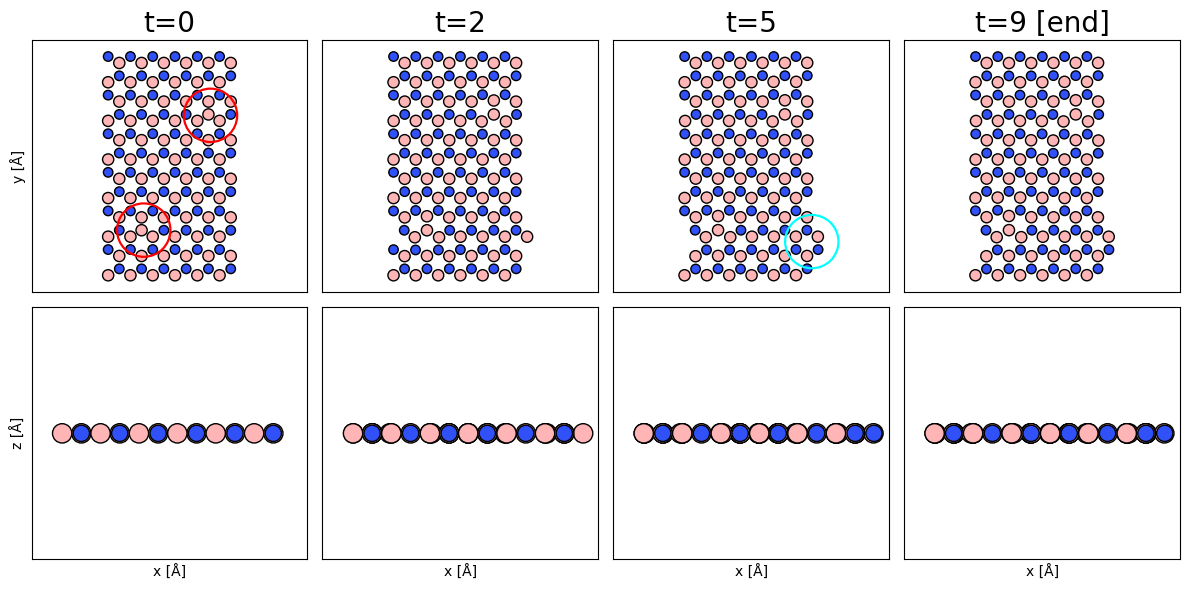

In [16]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(2,4, figsize=(12,6))

# prepare structure
#outplane
indices = [0, 2, 5, 12]
atoms_out      = [atoms_outplane[i] for i in indices]
atoms_out_orth = [abtem.orthogonalize_cell(atoms_out[i]) for i in range(len(atoms_out))]
atoms = atoms_out_orth

#inplane
indices = [0, 2, 5, 9]
atoms_in      = [atoms_inplane[i] for i in indices]
atoms_in_orth = [abtem.orthogonalize_cell(atoms_in[i]) for i in range(len(atoms_in))]
atoms = atoms_in_orth


# plot
for i in range(4):
    abtem.show_atoms(atoms[i], plane='xy',show_cell=False, ax=axs[0,i],)
    abtem.show_atoms(atoms[i], plane='xz',show_cell=False, ax=axs[1,i],)
    axs[0,i].xaxis.set_visible(False)
    axs[0,i].set_title(f't={indices[i]}', fontsize=20)

#axs[0,3].set_title(f't=12 [end]', fontsize=20) #out
axs[0,3].set_title(f't=9 [end]', fontsize=20) #in


# settings
for j in range(2):
    for i in range(3):
        axs[j, i+1].yaxis.set_visible(False)
    for i in range(4):
        axs[j,i].tick_params(axis='both',which='both', bottom=False, top=False, labelbottom=False,
                            left=False, labelleft=False)
for i in range(4):
    axs[1, i].set_xlim(-2,16)

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20,
         'axes.titlesize':'x-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# circles
axs[0,0].add_patch(Circle((4,5.8), 3, fill=False, color='red', linewidth=1.6, ))#ls='dashed'))
axs[0,0].add_patch(Circle((11.5,18.7), 3, fill=False, color='red', linewidth=1.6,))# ls='dashed'))
axs[0,2].add_patch(Circle((14.3,4.5), 3, fill=False, color='cyan', linewidth=1.6))#, ls='dashed'))


    
fig.tight_layout()
#fig.savefig(f'{results_folder}/../thesis/inplane_evolution1.png', bbox_inches='tight')

In [20]:
#view(atoms_outplane[0], viewer='x3d')
#view(a_orth, viewer='x3d')

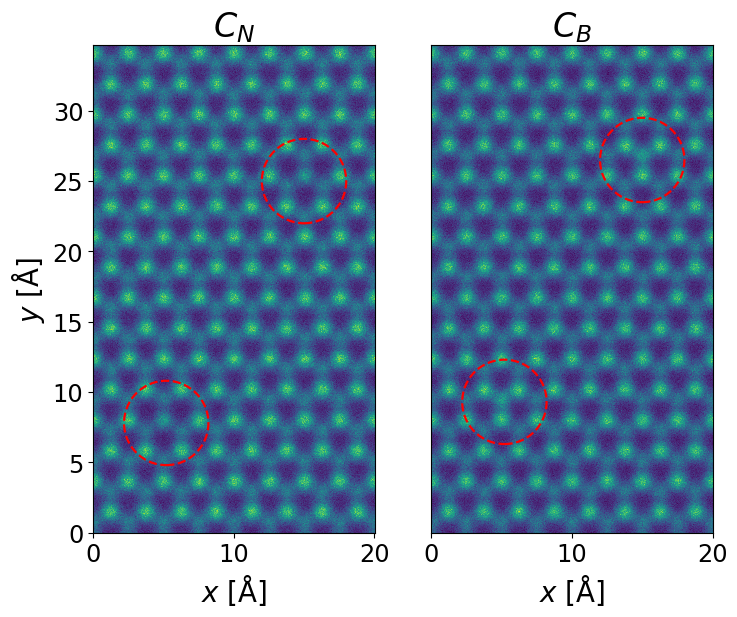

In [21]:
fig, axs = plt.subplots(1,2, figsize = (8,8), sharey=True)

noisy_measurements1[0].show(ax=axs[0], explode=False, cbar=False, title=True) 
noisy_measurements1[1].show(ax=axs[1], explode=False, cbar=False, title=True) 
axs[1].yaxis.set_visible(False)

for i in range(2):
    axs[i].set_title(params1[i], fontsize=24)

axs[0].add_patch(Circle((5.2,7.8), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))
axs[0].add_patch(Circle((15,25), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))
axs[1].add_patch(Circle((5.2,9.3), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))
axs[1].add_patch(Circle((15,26.5), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))


#fig.savefig(f'{results_folder}/../thesis/dft_cn_cb1.png', bbox_inches='tight')

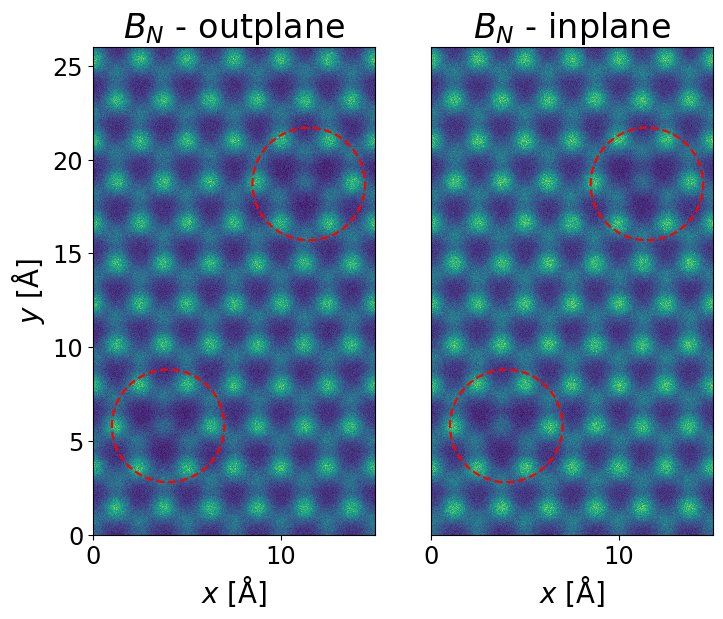

In [23]:
fig, axs = plt.subplots(1,2, figsize = (8,8), sharey=True)

noisy_measurements2[0].show(ax=axs[0], explode=False, cbar=False, title=True) 
noisy_measurements2[1].show(ax=axs[1], explode=False, cbar=False, title=True) 
axs[1].yaxis.set_visible(False)

for i in range(2):
    axs[i].set_title(params2[i], fontsize=24)
    axs[i].add_patch(Circle((4,5.8), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))
    axs[i].add_patch(Circle((11.5,18.7), 3, fill=False, color='red', linewidth=1.6, ls='dashed'))


#fig.savefig(f'{results_folder}/../thesis/dft_bn_inout.png', bbox_inches='tight')